# Classificação de Imagens: Detecção de Incêndios com ResNet-18 

Este notebook demonstra o processo de treinamento de um modelo de inteligência artificial, especificamente a ResNet-18, para classificar imagens entre duas categorias: `Fire` (contendo incêndio) e `No_Fire` (sem incêndio). O objetivo é construir um classificador capaz de identificar a presença de fogo em imagens, uma tarefa crucial para monitoramento ambiental e segurança..

O processo envolve várias etapas, desde a preparação do ambiente e exploração dos dados até o treinamento do modelo e avaliação de sua performance.

## 1. Instalação e Importação das Bibliotecas

A primeira etapa consiste em garantir que todas as bibliotecas necessárias para o projeto estejam instaladas e prontas para uso. Utilizamos o `pip` para instalar pacotes como `torch` e `torchvision` (para deep learning), `pandas` (manipulação de dados), `matplotlib` e `seaborn` (visualização), `opencv-python` (processamento de imagem), `scikit-learn` (métricas de avaliação), entre outras. Em seguida, importamos essas bibliotecas para o ambiente do notebook, tornando suas funcionalidades acessíveis.

In [ ]:
!pip install ipywidgets
!pip install pandas
!pip install opencv-python
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install torchvision
!pip install torch
!pip install kagglehub
!pip install kaggle
!pip install scikit-learn

In [16]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from PIL import Image, ImageFile
from sklearn.metrics import confusion_matrix, recall_score, f1_score
import warnings
from pathlib import Path
warnings.filterwarnings("ignore", category=FutureWarning)
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.nn import CrossEntropyLoss  
from torchvision.datasets import ImageFolder
import sys

## 2. Preparação dos Caminhos e Carregamento dos Dados

Nesta seção, definimos os caminhos para os diretórios que contêm as imagens de treinamento (`train`), validação (`valid`) e teste (`test`). É fundamental que as imagens dentro de cada um desses diretórios estejam organizadas em subpastas nomeadas de acordo com suas classes (neste caso, `Fire` e `No_Fire`).

A função `process_img` é definida para percorrer esses diretórios, listar todos os arquivos de imagem `.jpg`, extrair o rótulo (nome da pasta) de cada imagem e organizar essas informações em DataFrames do Pandas. Esses DataFrames (`train_df`, `val_df`, `test_df`) facilitam a manipulação e análise dos dados. Incluímos verificações para garantir que os diretórios existam e que imagens sejam encontradas, emitindo avisos caso contrário.

In [17]:
script_main_dir = os.getcwd()  # FIAP/src/
project_root_dir = os.path.join(script_main_dir, "..")  # FIAP/
path_main = os.path.join(project_root_dir, "dados", "processados")
path_main = os.path.normpath(path_main)
train_path = os.path.join(path_main, "train")
test_path = os.path.join(path_main, "test")
val_path = os.path.join(path_main, "valid")
print(f"Path Main: {path_main}")
print(f"Path train: {train_path}")
print(f"Path test: {test_path}")
print(f"Path valid: {val_path}")

Path Main: C:\Users\felip\Documents\FIAP\GlobalSolution_fase4_fiap\dados\processados
Path train: C:\Users\felip\Documents\FIAP\GlobalSolution_fase4_fiap\dados\processados\train
Path test: C:\Users\felip\Documents\FIAP\GlobalSolution_fase4_fiap\dados\processados\test
Path valid: C:\Users\felip\Documents\FIAP\GlobalSolution_fase4_fiap\dados\processados\valid


In [18]:
# percorrer recursivamente estrutura de diretórios
def walk_through_dir(filepath):
    for dirpath, dirnames, filenames in os.walk(filepath):
        print(
            f"Há  {len(dirnames)} diretórios e {len(filenames)} imagens em '{dirpath}'."
        )
    print()


def get_filetypes(filepath):
    exts = set(
        os.path.splitext(f)[1] for dir, dirs, files in os.walk(filepath) for f in files
    )
    print("Extensões de arquivo no diretório: ", exts)
    return exts


def process_img(filepath):
    filenames = list(Path(filepath).glob(r"**/*{}".format("jpg")))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filenames))

    filepaths = pd.Series(filenames, name="Filepath").astype(str)
    labels = pd.Series(labels, name="Label")

    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df.sample(frac=1)

In [19]:
train_df = process_img(train_path)
val_df = process_img(val_path)
test_df = process_img(test_path)

## 3. Exploração e Análise dos Dados (EDA - Exploratory Data Analysis)

Antes de treinar o modelo, é essencial entender as características do nosso conjunto de dados. Esta etapa de Análise Exploratória de Dados (EDA) nos ajuda a identificar padrões, possíveis problemas (como desbalanceamento de classes) e a tomar decisões informadas sobre o pré-processamento e o treinamento.

### 3.1. Análise da Distribuição das Classes

Verificamos quantas imagens pertencem a cada classe (`Fire` e `No_Fire`) em cada um dos conjuntos (treino, validação e teste). Isso é crucial porque um desbalanceamento significativo (uma classe com muito mais imagens que a outra) pode enviesar o treinamento do modelo, fazendo com que ele aprenda a prever majoritariamente a classe dominante. A visualização através de gráficos de barras torna essa distribuição fácil de interpretar. Se houver um desbalanceamento considerável, técnicas como oversampling, undersampling ou ajuste de pesos das classes no treinamento podem ser necessárias.

In [20]:
# Contagem de classes para cada conjunto de dados
train_counts = pd.Series(dtype="int")  # Inicializa como Series vazia
val_counts = pd.Series(dtype="int")
test_counts = pd.Series(dtype="int")

if "train_df" in locals() and not train_df.empty:
    train_counts = train_df["Label"].value_counts()
    print("Distribuição das classes no conjunto de Treino:")
    print(train_counts)
else:
    print("DataFrame de treino não definido ou vazio.")

if "val_df" in locals() and not val_df.empty:
    val_counts = val_df["Label"].value_counts()
    print("Distribuição das classes no conjunto de Validação:")
    print(val_counts)
else:
    print("DataFrame de validação não definido ou vazio.")

if "test_df" in locals() and not test_df.empty:
    test_counts = test_df["Label"].value_counts()
    print("Distribuição das classes no conjunto de Teste:")
    print(test_counts)
else:
    print("DataFrame de teste não definido ou vazio.")

Distribuição das classes no conjunto de Treino:
Label
Fire       15750
No_Fire    14500
Name: count, dtype: int64
Distribuição das classes no conjunto de Validação:
Label
Fire       3480
No_Fire    2820
Name: count, dtype: int64
Distribuição das classes no conjunto de Teste:
Label
Fire       3477
No_Fire    2820
Name: count, dtype: int64


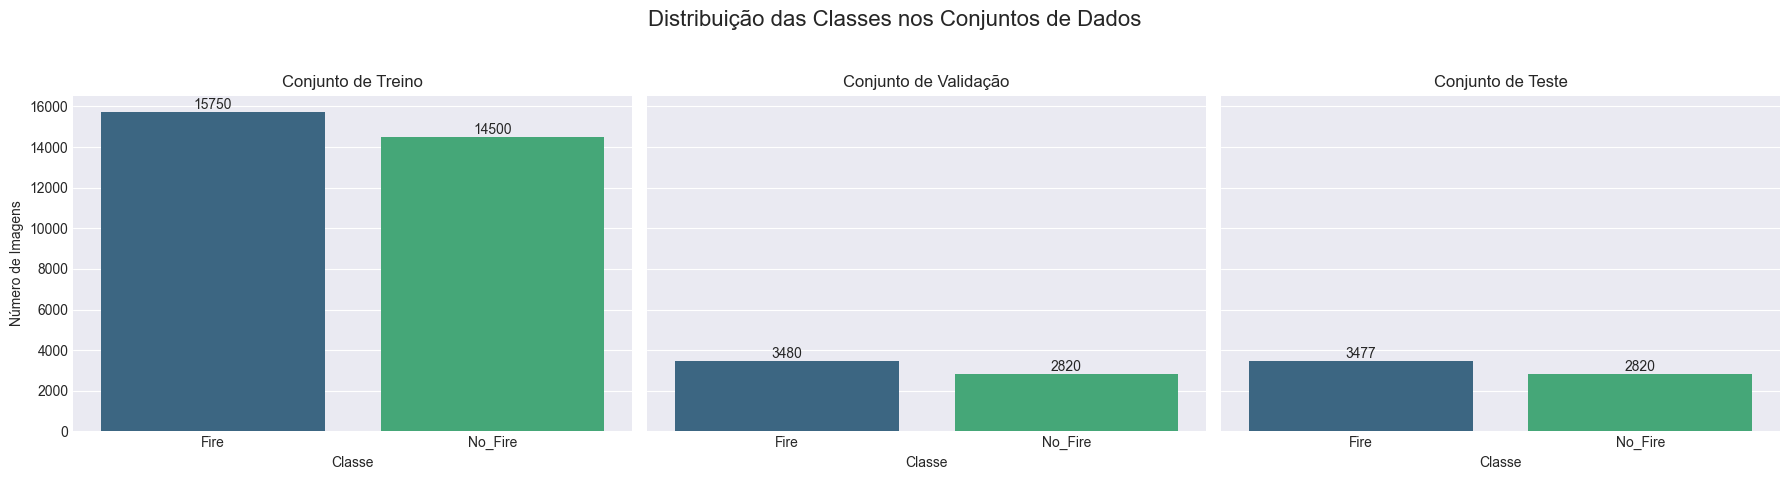

In [21]:
# Visualização da distribuição das classes
plt.style.use("seaborn-v0_8-darkgrid")  # Estilo mais moderno
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle("Distribuição das Classes nos Conjuntos de Dados", fontsize=16)

# Gráfico para Treino
if "train_df" in locals() and not train_df.empty and not train_counts.empty:
    sns.countplot(
        ax=axes[0],
        data=train_df,
        x="Label",
        palette="viridis",
        order=train_counts.index,
    )
    axes[0].set_title("Conjunto de Treino")
    axes[0].set_xlabel("Classe")
    axes[0].set_ylabel("Número de Imagens")
    for container in axes[0].containers:
        axes[0].bar_label(container)
else:
    axes[0].set_title("Conjunto de Treino (Dados Indisponíveis)")
    axes[0].text(
        0.5,
        0.5,
        "Verifique o carregamento",
        horizontalalignment="center",
        verticalalignment="center",
        transform=axes[0].transAxes,
    )

# Gráfico para Validação
if "val_df" in locals() and not val_df.empty and not val_counts.empty:
    sns.countplot(
        ax=axes[1], data=val_df, x="Label", palette="viridis", order=val_counts.index
    )
    axes[1].set_title("Conjunto de Validação")
    axes[1].set_xlabel("Classe")
    axes[1].set_ylabel("")  # Remover label Y repetido
    for container in axes[1].containers:
        axes[1].bar_label(container)
else:
    axes[1].set_title("Conjunto de Validação (Dados Indisponíveis)")
    axes[1].text(
        0.5,
        0.5,
        "Verifique o carregamento",
        horizontalalignment="center",
        verticalalignment="center",
        transform=axes[1].transAxes,
    )

# Gráfico para Teste
if "test_df" in locals() and not test_df.empty and not test_counts.empty:
    sns.countplot(
        ax=axes[2], data=test_df, x="Label", palette="viridis", order=test_counts.index
    )
    axes[2].set_title("Conjunto de Teste")
    axes[2].set_xlabel("Classe")
    axes[2].set_ylabel("")  # Remover label Y repetido
    for container in axes[2].containers:
        axes[2].bar_label(container)
else:
    axes[2].set_title("Conjunto de Teste (Dados Indisponíveis)")
    axes[2].text(
        0.5,
        0.5,
        "Verifique o carregamento",
        horizontalalignment="center",
        verticalalignment="center",
        transform=axes[2].transAxes,
    )

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajusta o layout para não sobrepor o título
plt.show()

### 3.2. Análise das Dimensões das Imagens (Amostra)

Modelos de deep learning geralmente exigem que todas as imagens de entrada tenham as mesmas dimensões (altura e largura). No entanto, imagens coletadas no mundo real raramente possuem tamanho uniforme. Analisar as dimensões originais de uma amostra das imagens nos ajuda a entender a variabilidade presente no dataset. Calculamos estatísticas descritivas (como média, mínimo, máximo e quartis) e visualizamos a distribuição das larguras e alturas através de histogramas. Essa análise justifica a necessidade da etapa de redimensionamento (`transforms.Resize`) no pré-processamento, garantindo que todas as imagens sejam padronizadas antes de serem alimentadas ao modelo.

In [22]:
from PIL import Image
import random


def get_image_dimensions(filepath):
    """Retorna as dimensões (largura, altura) de uma imagem."""
    try:
        with Image.open(filepath) as img:
            return img.size  # Retorna (width, height)
    except Exception as e:
        # print(f'Erro ao ler {filepath}: {e}') # Comentado para não poluir a saída
        return (None, None)


# Analisar apenas o conjunto de treino para ter uma ideia (pode ser lento para todos)
sample_df = pd.DataFrame()  # Inicializa vazio
if "train_df" in locals() and not train_df.empty:
    # Pega uma amostra para análise mais rápida (ex: 1000 imagens)
    sample_size = min(1000, len(train_df))
    if sample_size > 0:
        sample_df = train_df.sample(n=sample_size, random_state=42)

        print(f"Analisando dimensões de {sample_size} imagens de treino...")
        dimensions = sample_df["Filepath"].apply(get_image_dimensions)

        sample_df["Width"] = dimensions.apply(lambda x: x[0])
        sample_df["Height"] = dimensions.apply(lambda x: x[1])

        original_count = len(sample_df)
        sample_df.dropna(subset=["Width", "Height"], inplace=True)
        dropped_count = original_count - len(sample_df)
        if dropped_count > 0:
            print(
                f"{dropped_count} imagens não puderam ser lidas e foram removidas da análise de dimensão."
            )

        if not sample_df.empty:
            sample_df["Width"] = sample_df["Width"].astype(int)
            sample_df["Height"] = sample_df["Height"].astype(int)

            print("Estatísticas Descritivas das Dimensões (Amostra de Treino):")
            print(sample_df[["Width", "Height"]].describe())
        else:
            print(
                "Nenhuma imagem válida encontrada na amostra para análise de dimensões."
            )
    else:
        print("DataFrame de treino não contém imagens para amostrar.")
else:
    print("DataFrame de treino não definido ou vazio, pulando análise de dimensões.")

Analisando dimensões de 1000 imagens de treino...
Estatísticas Descritivas das Dimensões (Amostra de Treino):
        Width  Height
count  1000.0  1000.0
mean    350.0   350.0
std       0.0     0.0
min     350.0   350.0
25%     350.0   350.0
50%     350.0   350.0
75%     350.0   350.0
max     350.0   350.0


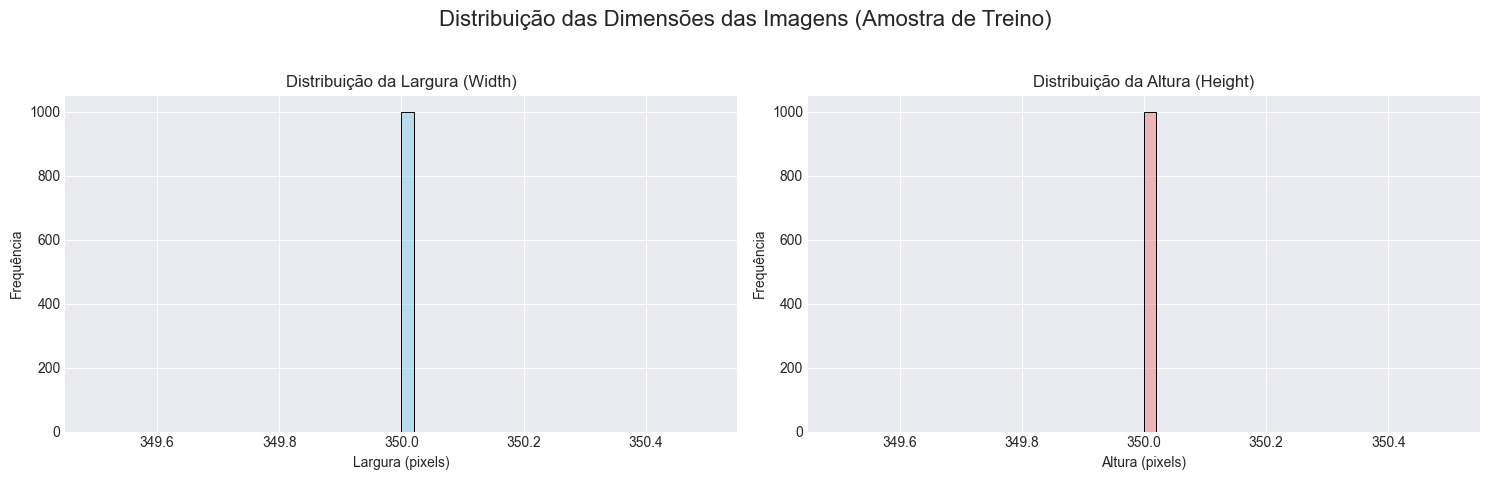

In [23]:
# Visualização das dimensões (Histogramas)
if (
    "sample_df" in locals()
    and not sample_df.empty
    and "Width" in sample_df.columns
    and "Height" in sample_df.columns
):
    plt.style.use("seaborn-v0_8-darkgrid")
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(
        "Distribuição das Dimensões das Imagens (Amostra de Treino)", fontsize=16
    )

    # Histograma da Largura
    sns.histplot(
        ax=axes[0], data=sample_df, x="Width", bins=50, kde=True, color="skyblue"
    )
    axes[0].set_title("Distribuição da Largura (Width)")
    axes[0].set_xlabel("Largura (pixels)")
    axes[0].set_ylabel("Frequência")

    # Histograma da Altura
    sns.histplot(
        ax=axes[1], data=sample_df, x="Height", bins=50, kde=True, color="lightcoral"
    )
    axes[1].set_title("Distribuição da Altura (Height)")
    axes[1].set_xlabel("Altura (pixels)")
    axes[1].set_ylabel("Frequência")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print(
        "Não foi possível gerar histogramas das dimensões (sem dados válidos ou colunas ausentes)."
    )

### 3.3. Verificação de Imagens e Rótulos (Amostra Visual)

Uma inspeção visual de algumas imagens aleatórias do conjunto de treinamento é uma forma eficaz de verificar a qualidade dos dados e a corretude dos rótulos associados. Exibimos uma grade de imagens com suas respectivas classes (`Fire` ou `No_Fire`). Isso nos permite confirmar se as imagens realmente correspondem às suas etiquetas e se não há problemas óbvios de qualidade (imagens corrompidas, muito escuras, etc.) que poderiam prejudicar o treinamento. É uma etapa de "verificação de sanidade" importante.

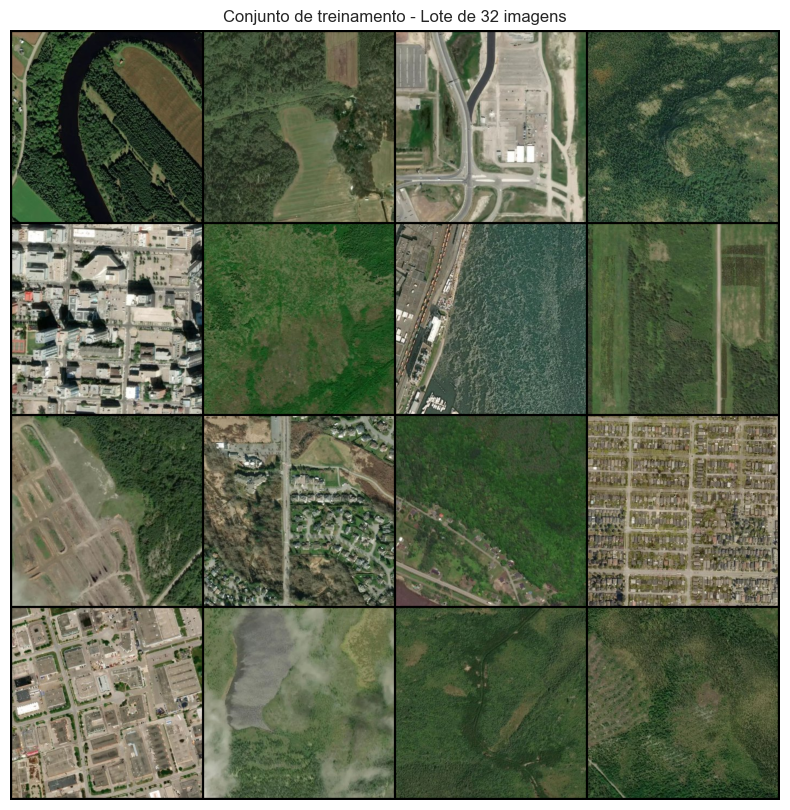

In [24]:
# ImageFolder - Classe de carregamento de dados das imagens onde cada sub classe
train_dataset = ImageFolder(root=train_path, transform=transforms.ToTensor())
train_loader=DataLoader(train_dataset,batch_size=16,shuffle=True)

def show_image_grid(loader, n_images=32, nrow=8, title="Image Grid"):
    # Obter um lote de imagens
    batch = next(iter(loader))
    transform=transforms.ToTensor()
    # Extrair imagens e rótulos
    images, labels = batch

    # Limitar o número de imagens às n_images especificadas
    images = images[:n_images]

    # Grade de imagens
    grid_img = torchvision.utils.make_grid(images, nrow=nrow, padding=4)

    # Converta a imagem da grade para numpy para exibição
    grid_img = grid_img.numpy().transpose(1, 2, 0)

    # Exibir a grade de imagens
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Exibir uma grade de 32 imagens do conjunto de treinamento
show_image_grid(train_loader, n_images=16, nrow=4, title="Conjunto de treinamento - Lote de 32 imagens")

## 4. Pré-processamento e Preparação dos Dados para o Modelo

Após a exploração inicial, preparamos os dados para serem utilizados pelo modelo ResNet-18. Isso envolve duas etapas principais: aplicar transformações às imagens e criar DataLoaders.

### 4.1. Transformações das Imagens

As transformações (`transforms`) são operações aplicadas a cada imagem antes que ela seja passada para o modelo. Elas servem para:
1.  **Padronização:** Redimensionamos todas as imagens para um tamanho fixo (256x256 pixels) para garantir consistência na entrada do modelo.
2.  **Augmentation (Aumento de Dados - apenas no treino):** Aplicamos transformações aleatórias como giros (`RandomRotation`), inversões horizontais (`RandomHorizontalFlip`) e verticais (`RandomVerticalFlip`) *apenas* nas imagens de treinamento. Isso cria variações sintéticas das imagens originais, ajudando o modelo a generalizar melhor e a ser mais robusto a diferentes orientações e perspectivas das cenas de incêndio (ou ausência dele). Não aplicamos augmentation nos dados de validação e teste para obter uma avaliação realista da performance do modelo em dados não vistos.
3.  **Conversão para Tensor:** Convertemos as imagens (que geralmente são carregadas como objetos PIL ou arrays NumPy) para Tensores do PyTorch, o formato de dados fundamental utilizado pela biblioteca.

Definimos conjuntos de transformações separados para treino (`train_transforms`) e para validação/teste (`testval_transform`).

In [25]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=30),
        transforms.ToTensor(),
    ]
)
testval_transform = transforms.Compose(
    [transforms.Resize((256, 256)), transforms.ToTensor()]
)


### 4.2. Criação dos Datasets e DataLoaders

Utilizamos a classe `ImageFolder` do `torchvision.datasets`, que é muito conveniente para carregar dados de imagem quando eles estão organizados em pastas por classe (como fizemos na Etapa 2). Ela automaticamente associa as imagens aos seus rótulos corretos com base na estrutura de diretórios e aplica as transformações definidas anteriormente.

Em seguida, criamos `DataLoaders` para cada conjunto (treino, validação, teste). Os DataLoaders são iteradores que agrupam os dados em *batches* (lotes), embaralham os dados de treinamento a cada época (para evitar que o modelo aprenda a ordem dos dados) e podem paralelizar o carregamento dos dados (`num_workers`), tornando o processo de alimentação do modelo durante o treinamento mais eficiente.

In [26]:
train_dataset = ImageFolder(root=train_path, transform=train_transforms)
test_dataset = ImageFolder(root=test_path, transform=testval_transform)
valid_dataset = ImageFolder(
    root=val_path,
    transform=testval_transform,
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

## 5. Configuração do Modelo (ResNet-18)

Selecionamos a arquitetura ResNet-18 como nosso modelo de classificação. A ResNet-18 é uma rede neural convolucional (CNN) conhecida por seu bom equilíbrio entre profundidade (18 camadas) e eficiência computacional. Suas "conexões residuais" ajudam a treinar redes mais profundas de forma eficaz.

Utilizamos *transfer learning* ao carregar a ResNet-18 com pesos pré-treinados na vasta base de dados ImageNet (`weights=models.ResNet18_Weights.IMAGENET1K_V1`). Isso significa que o modelo já aprendeu a reconhecer características visuais gerais, o que acelera nosso treinamento e geralmente leva a melhores resultados, especialmente com datasets menores.

Como a ResNet-18 pré-treinada foi originalmente feita para classificar 1000 classes do ImageNet, precisamos adaptar sua última camada (a camada *fully connected*, `fc`) para o nosso problema específico, que tem apenas 2 classes (`Fire` e `No_Fire`). Substituímos a camada `fc` original por uma nova camada linear que produz 2 saídas.

Também definimos o dispositivo de computação (`cuda` se uma GPU NVIDIA estiver disponível, `mps` para GPUs Apple Silicon, ou `cpu` caso contrário) e movemos o modelo para esse dispositivo. Finalmente, configuramos o otimizador (`Adam`, um algoritmo popular para ajustar os pesos do modelo durante o treinamento) e a função de perda (`CrossEntropyLoss`, adequada para problemas de classificação multi-classe ou binária).

In [27]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1) 
if torch.cuda.is_available():
    device_str = 'cuda'
elif sys.platform == 'darwin' and torch.backends.mps.is_available():
    # Verifica se o SO é macOS ('darwin') e se o backend MPS está disponível
    device_str = 'mps'
else:
    device_str = 'cpu'
device = torch.device(device_str)
print(device)
model.to(device)
# definir otimizador e função de perda
optimizer=Adam(model.parameters(),lr=0.001)
loss_fn=CrossEntropyLoss()

cuda


## 6. Treinamento do Modelo

Esta é a etapa central onde o modelo aprende a classificar as imagens. O treinamento ocorre ao longo de várias *épocas*. Em cada época, o modelo processa todo o conjunto de treinamento.

O processo dentro de cada época envolve:
1.  **Fase de Treinamento (`model.train()`):**
    *   O DataLoader de treino fornece imagens e rótulos em lotes (batches).
    *   Para cada lote, as imagens são passadas pelo modelo para obter previsões (`outputs`).
    *   A função de perda (`loss_fn`) calcula o quão erradas estão as previsões em comparação com os rótulos verdadeiros.
    *   O otimizador (`optimizer`) usa essa perda para calcular os gradientes (direção do erro) e ajustar os pesos do modelo (`loss.backward()`, `optimizer.step()`) para minimizar o erro na próxima vez.
    *   A perda de treinamento da época é a média das perdas de todos os lotes.
2.  **Fase de Validação (`model.eval()`):**
    *   Após processar todo o conjunto de treino, o modelo é colocado em modo de avaliação (desativa camadas como Dropout, se houver).
    *   O DataLoader de validação fornece imagens e rótulos.
    *   O modelo faz previsões nos dados de validação *sem* ajustar seus pesos (`torch.no_grad()`).
    *   Calculamos a perda média de validação e a acurácia de validação (percentual de previsões corretas).

Monitoramos a perda de treinamento, a perda de validação e a acurácia de validação a cada época. Idealmente, a perda de treinamento e validação devem diminuir, enquanto a acurácia de validação deve aumentar. Isso indica que o modelo está aprendendo e generalizando bem para dados não vistos durante o treino.

In [28]:
num_epochs = 10
num_classes = 2
train_losses = []
val_losses = []
val_accuracies = []

ImageFile.LOAD_TRUNCATED_IMAGES = True
model.train()  # Define o modelo para o modo de treinamento
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)  # Migrar para GPU/CPU

        optimizer.zero_grad()  # Zerar os gradientes
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Fase de avaliação
    model.eval()  # Defina o modelo para o modo de avaliação
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)  # Migrar para GPU/CPU
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            _, y_pred = torch.max(outputs, 1) 
            correct += (y_pred == labels).sum().item()  # Contar as previsões corretas

    val_losses.append(val_loss / len(valid_loader))
    val_accuracy = correct / len(valid_dataset)
    val_accuracies.append(val_accuracy)

    print(f"Época [{epoch+1}/{num_epochs}] - "
          f"Perda de treinamento: {train_loss:.4f}, "
          f"Validação perdida: {val_loss/len(valid_loader):.4f}, "
          f"Precisão de Validação: {val_accuracy:.4f}")

Época [1/10] - Perda de treinamento: 0.1847, Validação perdida: 0.1367, Precisão de Validação: 0.9576
Época [2/10] - Perda de treinamento: 0.3468, Validação perdida: 0.1621, Precisão de Validação: 0.9362
Época [3/10] - Perda de treinamento: 0.1782, Validação perdida: 0.1205, Precisão de Validação: 0.9527
Época [4/10] - Perda de treinamento: 0.1532, Validação perdida: 0.1165, Precisão de Validação: 0.9575
Época [5/10] - Perda de treinamento: 0.1430, Validação perdida: 0.1190, Precisão de Validação: 0.9557
Época [6/10] - Perda de treinamento: 0.1274, Validação perdida: 0.0990, Precisão de Validação: 0.9654
Época [7/10] - Perda de treinamento: 0.1216, Validação perdida: 0.1003, Precisão de Validação: 0.9640
Época [8/10] - Perda de treinamento: 0.1165, Validação perdida: 0.1177, Precisão de Validação: 0.9587
Época [9/10] - Perda de treinamento: 0.1138, Validação perdida: 0.0884, Precisão de Validação: 0.9668
Época [10/10] - Perda de treinamento: 0.1092, Validação perdida: 0.0963, Precisão 

## 7. Visualização da Performance do Modelo

Após o treinamento, é fundamental visualizar como a performance do modelo evoluiu ao longo das épocas. Plotamos dois gráficos:
1.  **Gráfico de Perda (Loss):** Mostra a perda de treinamento e a perda de validação em cada época. Esperamos que ambas as curvas diminuam com o tempo. Se a perda de treinamento continua caindo, mas a de validação começa a subir, isso é um sinal de *overfitting* (o modelo está memorizando os dados de treino, mas não generaliza bem para novos dados).
2.  **Gráfico de Acurácia (Accuracy):** Mostra a acurácia no conjunto de validação a cada época. Esperamos que essa curva suba e se estabilize em um valor alto. 

Esses gráficos nos ajudam a diagnosticar problemas no treinamento e a entender se o número de épocas foi adequado.

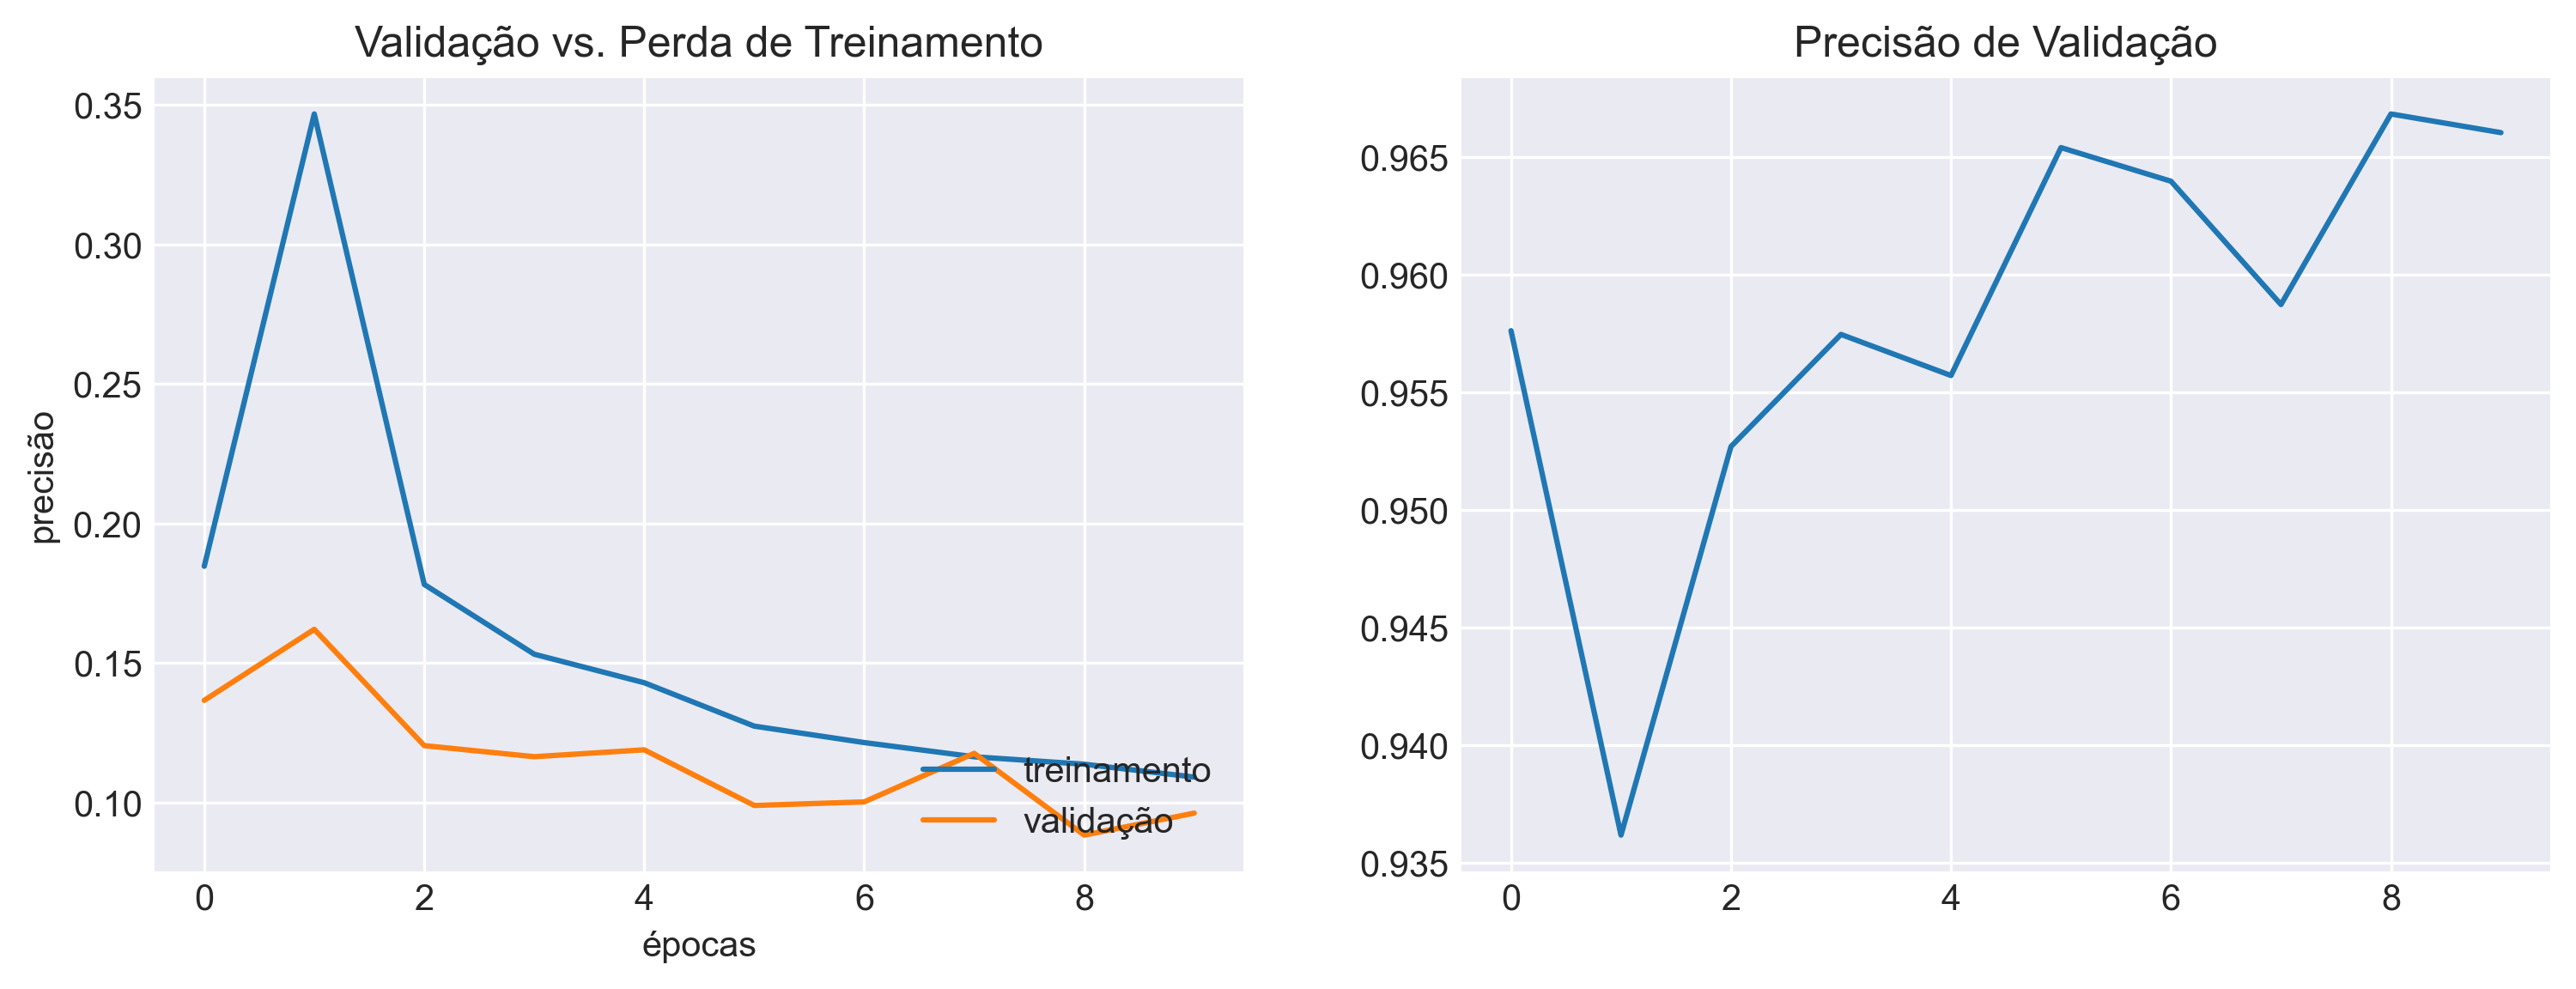

In [29]:
plt.figure(figsize=(12, 4), dpi=300)

plt.subplot(1, 2, 1)
plt.title('Validação vs. Perda de Treinamento')
plt.plot(train_losses, label = 'treinamento')
plt.plot(val_losses, label = 'validação')

plt.legend(loc = 'lower right')
plt.xlabel('épocas')
plt.ylabel('precisão')

plt.subplot(1,2,2)
plt.title('Precisão de Validação')
plt.plot(val_accuracies, label = 'val_accuracy')

# Mostrar report
plt.show()

## 8. Avaliação Final no Conjunto de Teste

A avaliação final e mais importante da performance do modelo é feita no conjunto de teste, que contém dados completamente novos, não utilizados durante o treinamento ou a validação. Isso nos dá uma estimativa imparcial de como o modelo se comportará em situações reais.

Calculamos e exibimos duas métricas principais:
1.  **Relatório de Classificação (`classification_report`):** Fornece métricas detalhadas por classe, como:
    *   **Precisão (Precision):** De todas as vezes que o modelo previu uma classe (ex: `Fire`), quantas vezes ele acertou? (Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Positivos))
    *   **Revocação (Recall) / Sensibilidade:** De todas as imagens que realmente pertenciam a uma classe (ex: `Fire`), quantas o modelo conseguiu identificar corretamente? (Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Negativos))
    *   **F1-Score:** Média harmônica entre precisão e revocação, útil para avaliar o equilíbrio entre as duas.
    *   **Support:** Número de ocorrências reais de cada classe no conjunto de teste.
2.  **Matriz de Confusão (`confusion_matrix`):** Uma tabela que visualiza o desempenho do classificador. As linhas representam as classes verdadeiras e as colunas representam as classes previstas. Ela mostra quantos exemplos foram classificados corretamente (diagonal principal) e quantos foram classificados incorretamente (fora da diagonal), e especificamente quais erros de classificação ocorreram (ex: quantas imagens `No_Fire` foram classificadas como `Fire`).

Essas métricas nos dão uma visão completa da capacidade do modelo em distinguir corretamente entre imagens com e sem incêndio.

In [30]:
all_labels=[]
all_preds=[]
model=model.to(device)
model.eval()
total=0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs,labels=inputs.to(device),labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Teste de precisão: {accuracy:.2f}")


Teste de precisão: 1.93


# Revocação 

In [31]:
recall = recall_score(all_labels, all_preds, pos_label=1)
print(f"Revocação (Recall): {recall:.4f}")

Revocação (Recall): 0.9741


#  F1-Score

In [32]:
f1 = f1_score(all_labels, all_preds, pos_label=1)
print(f"F1-Score: {f1:.4f}")

F1-Score: 0.9642


# Especificidade 

In [33]:
Specificity = recall_score(all_labels, all_preds, pos_label=0)
print(f"Especificidade: {Specificity:.4f}")

Especificidade: 0.9623


# Matriz de Confusão 

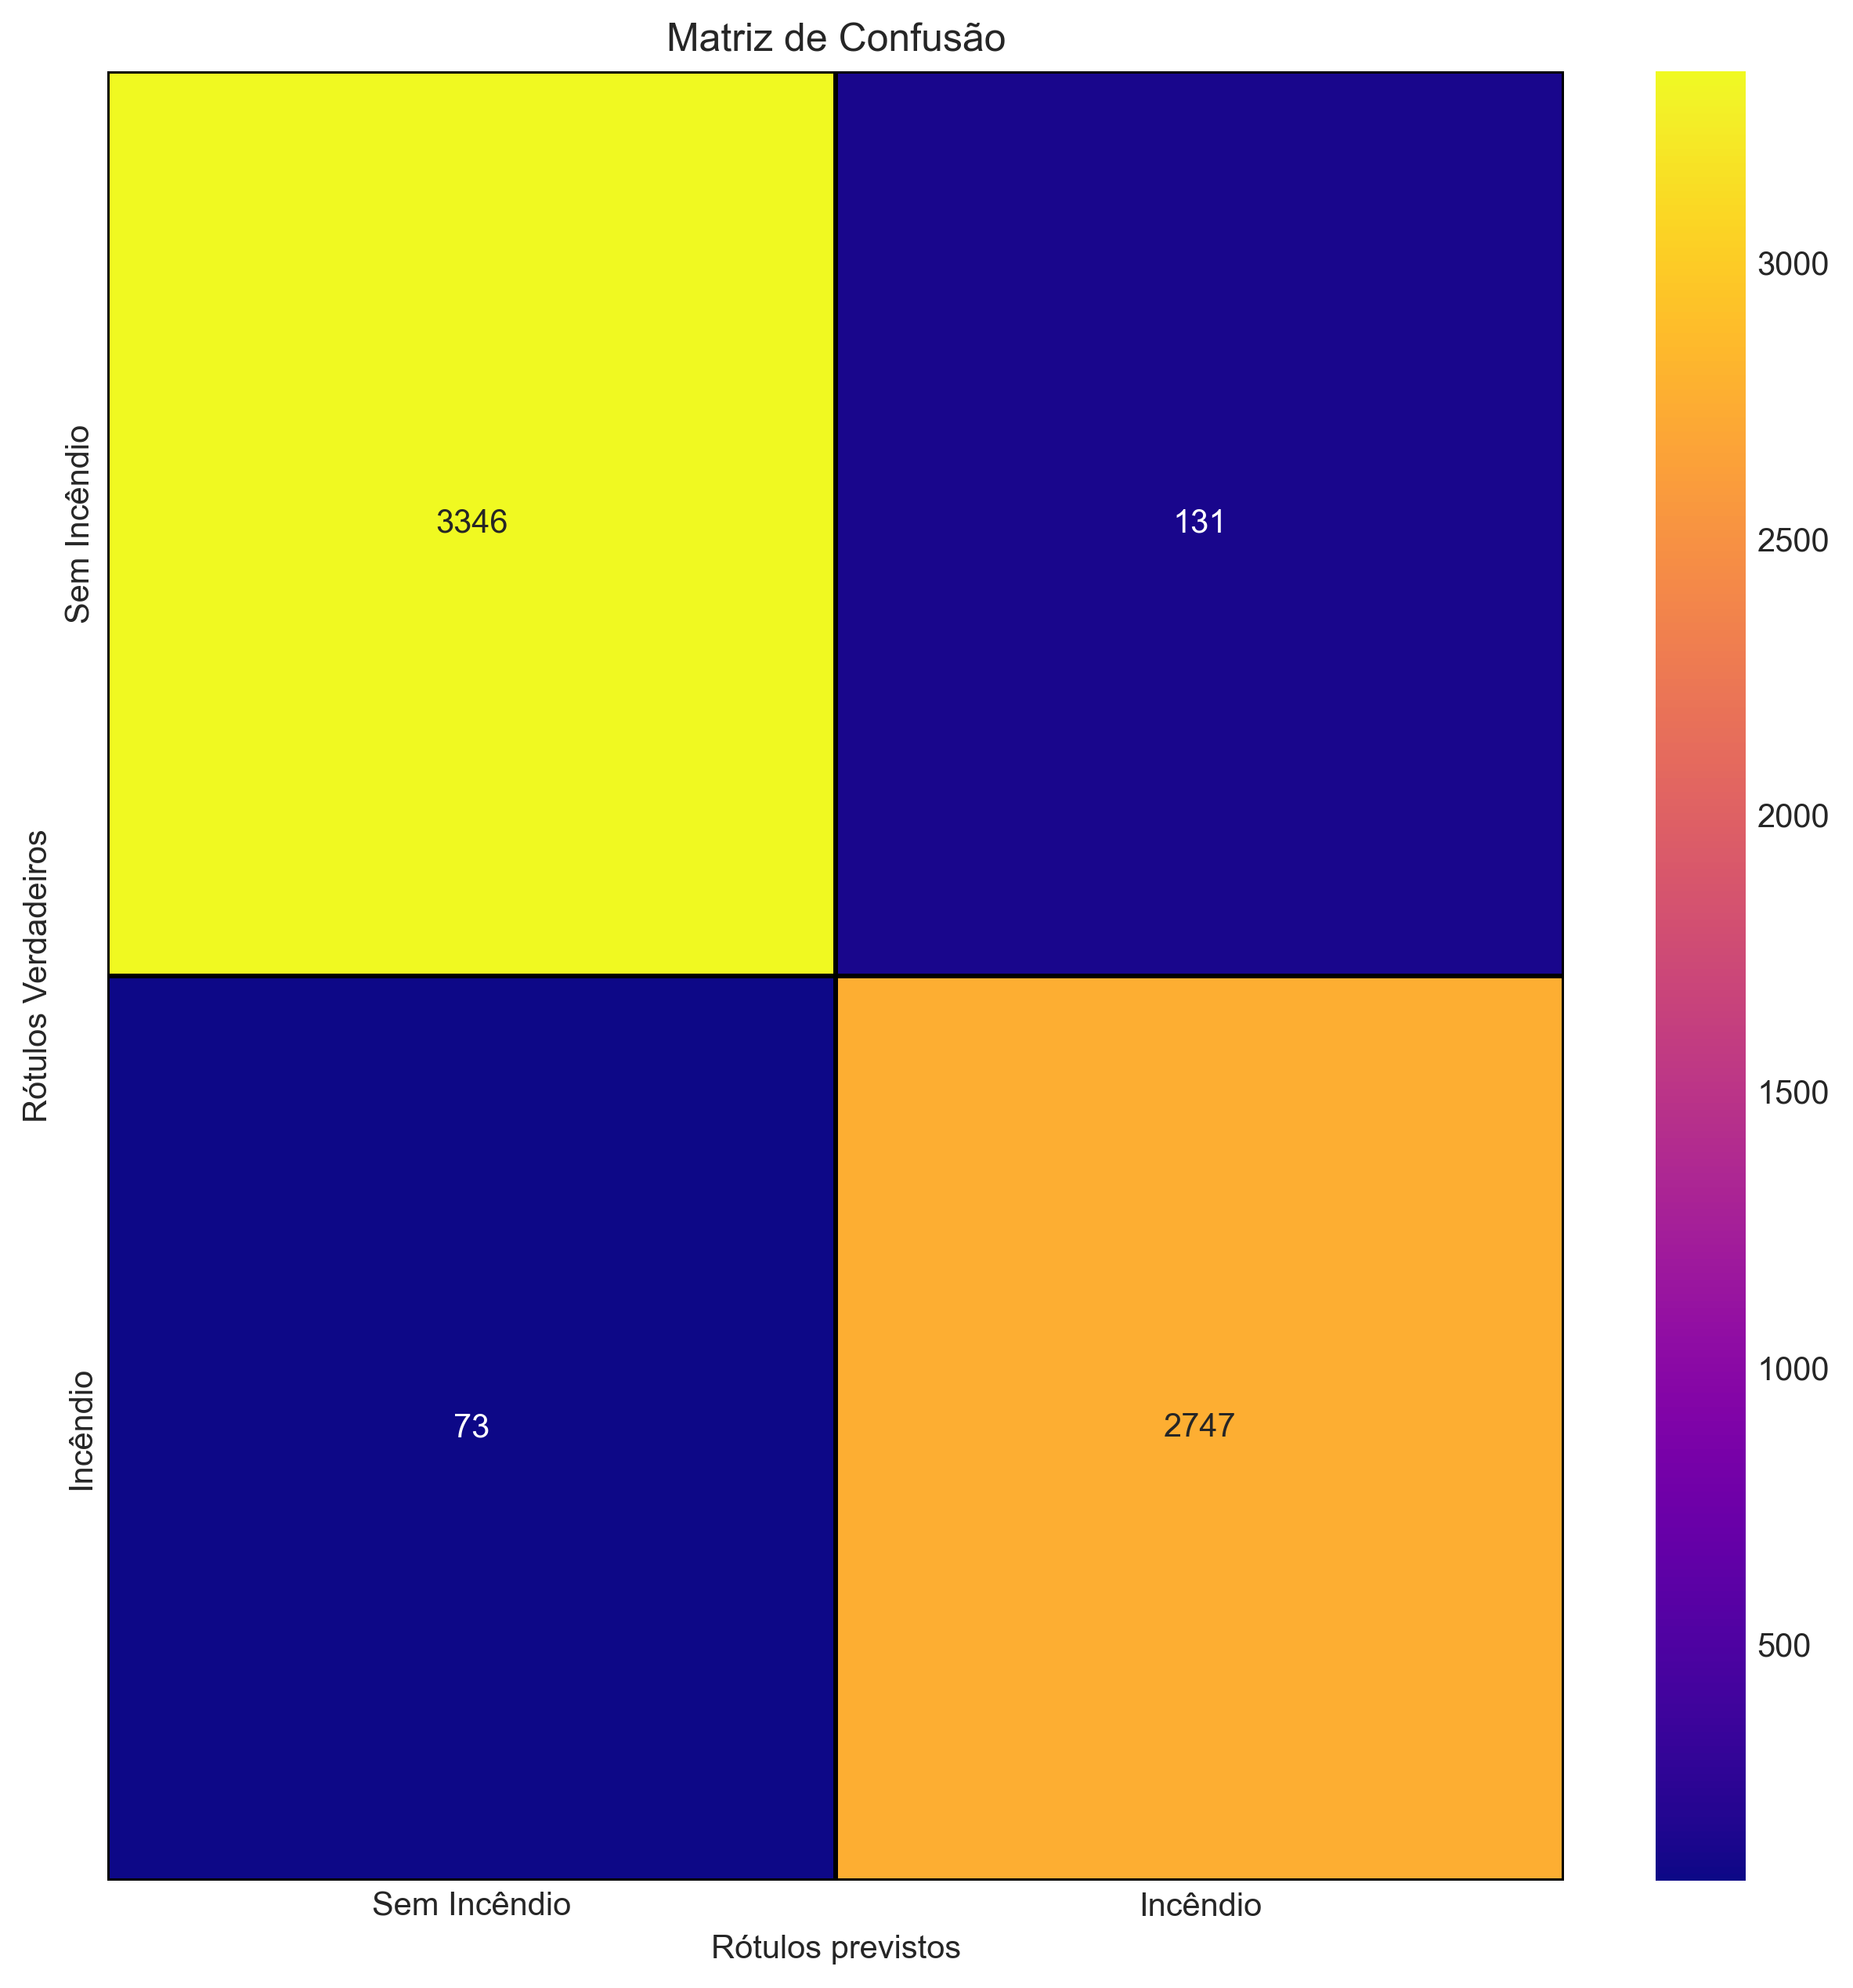

In [34]:
classes=['Sem Incêndio','Incêndio']

cm=confusion_matrix(all_labels,all_preds)
plt.figure(figsize=(10, 10), dpi=300)
sns.heatmap(cm, annot=True, fmt='d', cmap="plasma"
            , linewidths=1,
            linecolor="black", xticklabels=classes, yticklabels=classes)
plt.xlabel('Rótulos previstos')
plt.ylabel('Rótulos Verdadeiros')
plt.title('Matriz de Confusão')
plt.show()



### 9. Inspeção visual

.Fornece uma inspeção visual rápida de como o modelo está se saindo na classificação de imagens. Ao exibir as imagens com suas previsões e rótulos reais (colorindo-os para indicar acerto ou erro), você pode facilmente identificar:

Onde o modelo está acertando: Imagens com títulos verdes.
Onde o modelo está errando: Imagens com títulos vermelhos, o que pode te dar insights sobre os tipos de imagens que o modelo tem dificuldade em classificar.

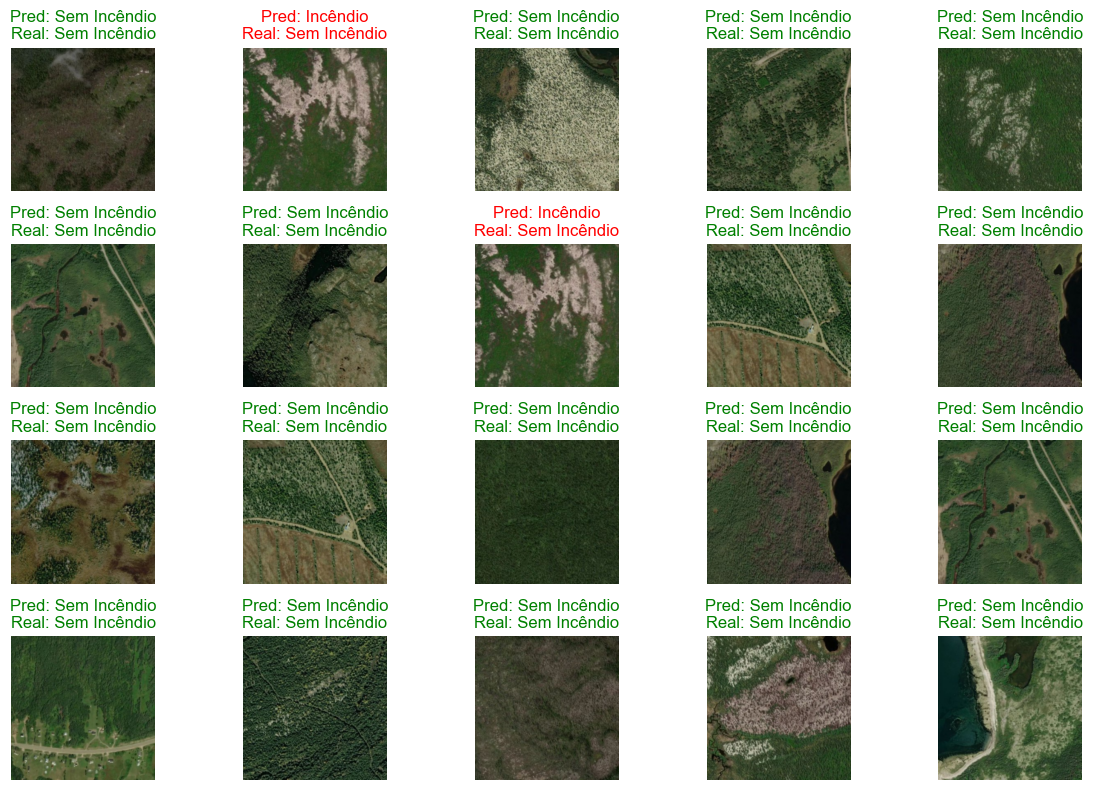

In [36]:
# Defina o número de imagens, linhas e colunas
num_images = 20
num_rows = 4
num_cols = 5

# Criar figura
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Defina o modelo para o modo de avaliação
model=model.to(device)
model.eval()

# Sem computação de gradiente
with torch.no_grad():
    # Faça um loop sobre o número de imagens que queremos exibir
    for i in range(num_images):
        img, label = next(iter(test_loader)) 
        img, label=img.to(device),label.to(device)
        # Selecione uma imagem aleatória do lote
        index = np.random.randint(0, len(img))
        img_to_show = img[index]
        label_to_show = label[index]

        # Certifique-se de que a imagem esteja na CPU e remova a dimensão do lote
        img_to_show = img_to_show.to('cpu')
        img_to_show = img_to_show.permute(1, 2, 0) 

        # Faça previsões
        outputs = model(img[index].unsqueeze(0))
        _, predicted_index = torch.max(outputs, 1)
        color = 'green' if predicted_index.item() == label_to_show.item() else 'red'


        # Exibir a imagem
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(img_to_show, cmap='gray')
        ax.set_title(f"Pred: {classes[predicted_index.item()]}\nReal: {classes[label_to_show.item()]}", color=color)
        ax.axis('off') 

plt.tight_layout()
plt.show()

# Exportação do Modelo

In [24]:
# Define o caminho onde os pesos serão salvos
PATH_PESOS = "modelo_incendio.pth"
torch.save(model.state_dict(), PATH_PESOS)
print(f"Pesos do modelo salvos em: {PATH_PESOS}")

Pesos do modelo salvos em: modelo_incendio.pth
